In every files throughout **Postgres'** learning, we have connected to the Postgres database using the `psycopg2.connect()` function with the connection string `"dbname=dq user=dq"`. We briefly mentioned that this was to connect to a specific database and user, but did not pursue the reasons why Postgres requires these parameters. 

In this file, we will explore Postgres user and database management commands to create and configure commonly used roles for accessing the database.

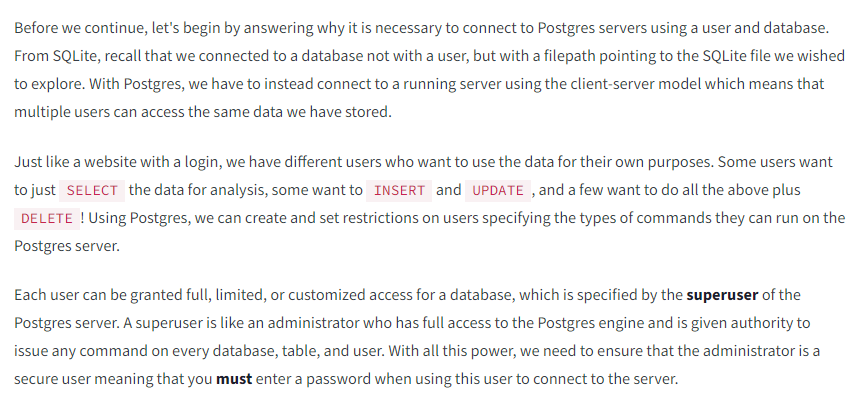

Throughout, we have connected to the Postgres server like so:
    
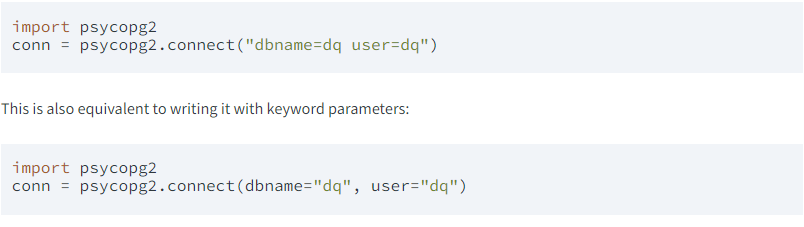

There are other keyword arguments that can be passed to the connect method. For a complete list of connections parameters, we recommend to check the [`psycopg2` documentation page](https://www.psycopg.org/docs/module.html).

One of these parameter is `password`, which is used to specify the password of the given user. So far, we did not specify it when connecting with the `dq` user, because this user is not password protected. Therefore, the `dq` user is not a secured user — anyone entering that username could connect to our server and have full access to our data. That is a major security flaw that we will describe in more detail.

Let's try to connect with a password protected user.

**Task**

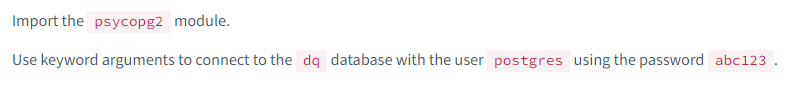

**Asnwer**

`import psycopg2
conn = psycopg2.connect(dbname='dq', user='postgres', password='abc123')
print(conn)`

Above we connected with the `postgres` user instead of the usual `dq` user from the previous files. The `postgres` user is the default superuser in **Postgres**. The `dq` user is just another user we created so that we could access the server without having to enter in a password.

While it's easy to teach using an unsecured user, is not a good idea for a real **Postgres server** since all our data is essentially publicly exposed with a password-free user. 

To create the `dq` user in **Postgres**, we had to first connect with the `postgres` user and then use the `CREATE USER` command. This command provides a variety of options such as `PASSWORD`, `CREATEDB`, and others which specify the database permissions of the user.

Here's how we could create a user with password `abcd123` that's allowed to create databases:

`CREATE USER new_user WITH CREATEDB PASSWORD 'abcd123';`

In the above command, we created a user using options `CREATEDB` and `PASSWORD`. As the names indicate, 

* the first one means that the user is allowed to create databases and
* the second that it has a password with value `abcd123`. 

There are several options available for creating users. These can be found in the [documentation of `CREATE USER`](https://www.postgresql.org/docs/9.5/sql-createuser.html).

Most commands have a corresponding negative command saying that the user is not allowed to perform a specific action. For instance, the `CREATEDB` negative command is `NOCREATEDB`. The general rule is the negative commands have the same name but are prefixed with a **NO**. By default, all negative options are set so that we have to explicitly tell what we want the user to be able to do.

**Task**

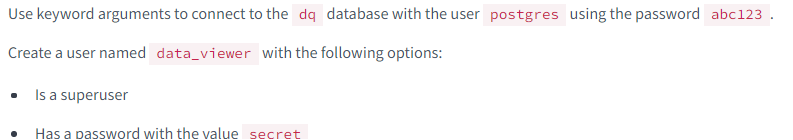

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='dq', user='postgres', password='abc123')
cur = conn.cursor()
cur.execute("CREATE USER data_viewer WITH SUPERUSER PASSWORD 'secret';")
conn.commit()
conn.close()`



As with everything else, **Postgres** has an internal table to store its users. This table is called `pg_user`. It is a useful table to know about for user management. It allows us to check which users the database contains and the type of users they are.

From the [Postgres `pg_user` table documentation](https://www.postgresql.org/docs/9.5/view-pg-user.html) we see that it contains nine columns. The most important columns are:

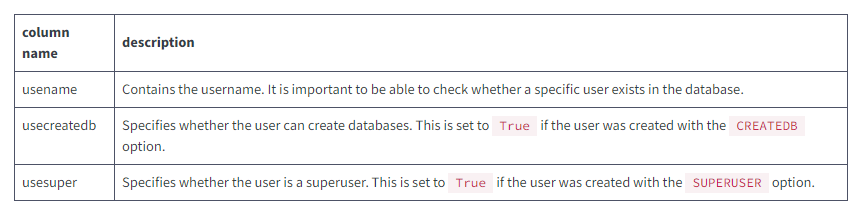

Usually, we will not want to have more than one superuser. This is usually the default `postgres` user and it should be used only for database administration tasks like **creating other users**, **roles**, and **databases**.

Let's take a peek at the `pg_user` table to see what users we have on the database.

**Task**

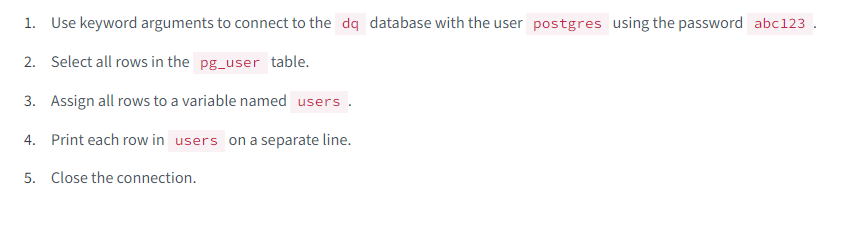

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='dq', user='postgres', password='abc123')
cur = conn.cursor()
cur.execute("SELECT * FROM pg_user;")
users = cur.fetchall()
for user in users:
    print(user)
conn.close()`

Above we listed all rows in the `pg_user` table and obtained the following three users: 
1. the `postgres` user, which is the default database administrator; 
2. the `dq`, which is the user that we have using in the previous files; and
3. the `data_viewer` user that we have just created.

Creating a password is the first step to securing a user on a Postgres server. The next step is to make sure that we only give a user a certain amount of commands that we want them to be able to issue on the server. These commands are called **user privileges** which are outlined in the [Postgres user privilege documentation](https://www.postgresql.org/docs/9.1/ddl-priv.html).

These privileges are the rules that allow a user to run `SELECT`, `INSERT`, `DELETE`, `DROP TABLE`, or any other command that we have learned. Most of the time, we don't want users to be able to issue any destructive command like `DROP`, `DELETE`, or `UPDATE` on our tables since this could cause us to lose important data. It's not just malicious users like hackers that could delete vital data but also unaware users that issue the wrong commands.

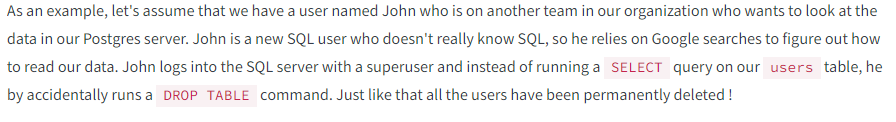

While this example might seem far-fetched, there are hundreds of horror stories online that have had this exact scenario happen. Here is one such [example](https://thenewstack.io/junior-dev-deleted-production-database/). To prevent this from happening, we, the database owner, should be protecting well intentioned users from making this type of mistake. The way we can stop a user from making this mistake is by **revoking** privileges from users using the [`REVOKE` command](https://www.postgresql.org/docs/9.1/sql-revoke.html).

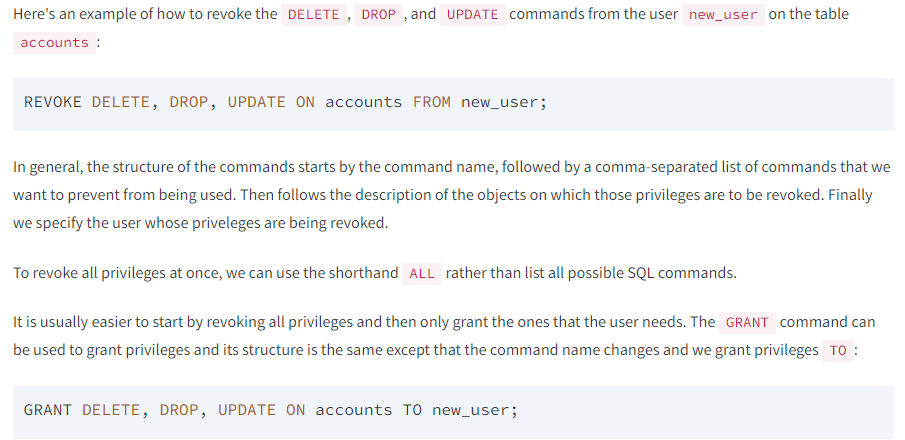

**Task**

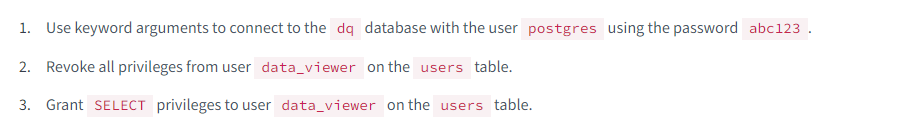

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='dq', user='postgres', password='abc123')
cur = conn.cursor()
cur.execute("REVOKE ALL ON users FROM data_viewer;")
cur.execute("GRANT SELECT ON users TO data_viewer;")
conn.commit()
conn.close()`

Above we set up a user named `data_viewer` who is a superuser and has only `SELECT` privileges. In a production database, we may have a lot of users; for user management purposes, it is important to be able to see what privileges a given user has.

For privileges related to tables, this information is contained in a Postgres internal table named `information_schema.table_privileges`. From the [documentation of the `table_privileges` table](https://www.postgresql.org/docs/9.3/infoschema-table-privileges.html), we see that this table possesses eight columns. The most important ones are described below:

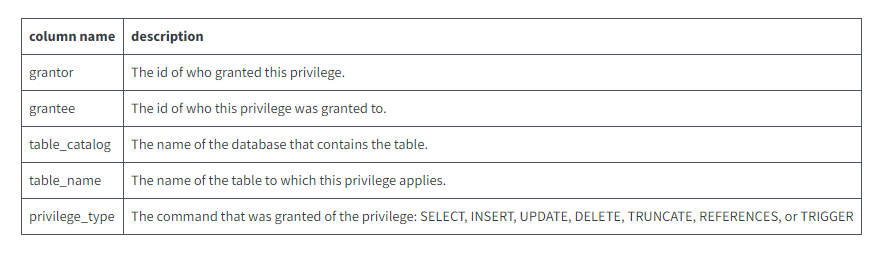

Let's use this to verify that what we did earlier is correct. That is, that the `data_viewer` user has only `SELECT` privileges on the `users` table.

**Task**

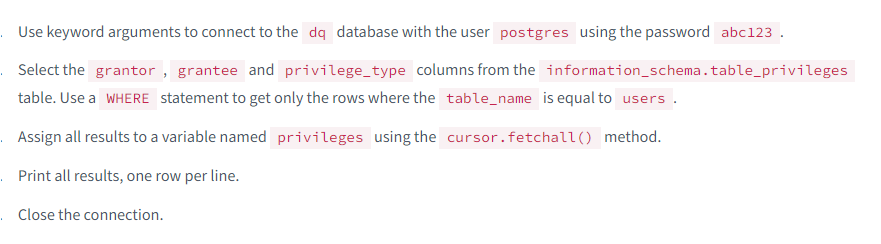

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='dq', user='postgres', password='abc123')
cur = conn.cursor()`

`cur.execute("""
    SELECT grantor, grantee, privilege_type
    FROM information_schema.table_privileges
    WHERE table_name = 'users';
""")
privileges = cur.fetchall()
for row in privileges:
    print(row)`

`conn.commit()
conn.close()`

After inspecting the user privileges on the users table above, we obtained the following list of privileges:

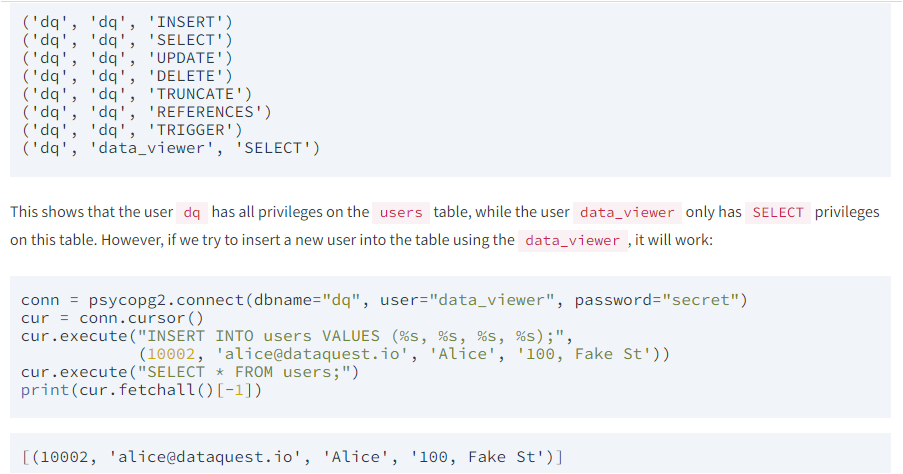

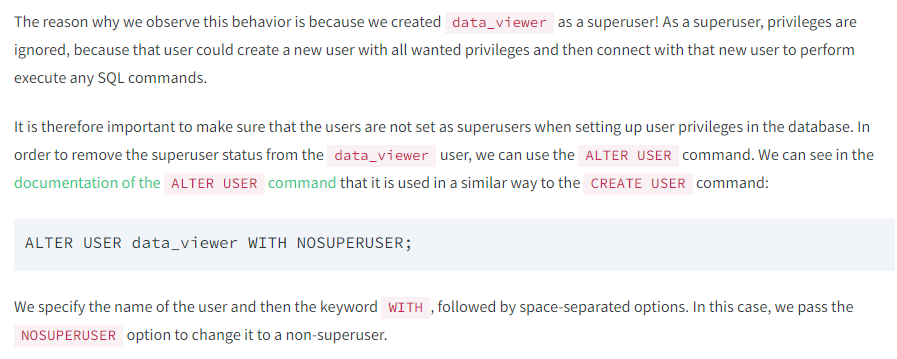

Let's try this and see if we can still make the above query afterwards.

**Task**

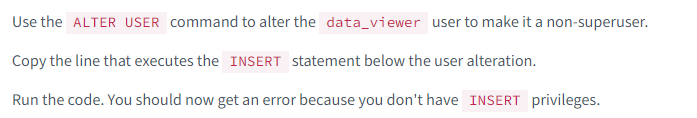

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname="dq", user="data_viewer", password="secret")
cur = conn.cursor()`

`cur.execute("INSERT INTO users VALUES (%s, %s, %s, %s);", 
            (10002, 'alice@dataquest.io', 'Alice', '100, Fake St'))
cur.execute("SELECT * FROM users;")
print(cur.fetchall()[-1])`

`cur.execute("ALTER USER data_viewer NOSUPERUSER;")
cur.execute("INSERT INTO users VALUES (%s, %s, %s, %s);", 
            (10002, 'alice@dataquest.io', 'Alice', '100, Fake St'))`

The type of user we have created above is called a **readonly** user. A readonly user is defined as a user who has no other privileges except for being able to read data from our database.

In general, it is recommended that each user should have only the privileges that are strictly required for the kind of tasks that are requited for the job. This is known as the **least privilege principle**.

The readonly user follows this principle by allowing the user to only read data. This is likely the type of user profile that we would set up for a data analyst as, in general, such a user needs only to be able to access the data for analysis.

Imagine that we are deploying a Postgres database for a large user base and, say, 100 users are data analysts who only need read privileges over the data. It would be very cumbersome and time consuming to have to manually set up the privileges of each and every one of those 100 users.

Fortunately, Postgres offers a quick and convenient way of doing this by creating a [user `GROUP!`](https://www.postgresql.org/docs/9.1/sql-creategroup.html) Instead of revoking and granting for a single user, we create group with the adequate privileges and then simply place a user inside a group. This configuration would look like the following figure:

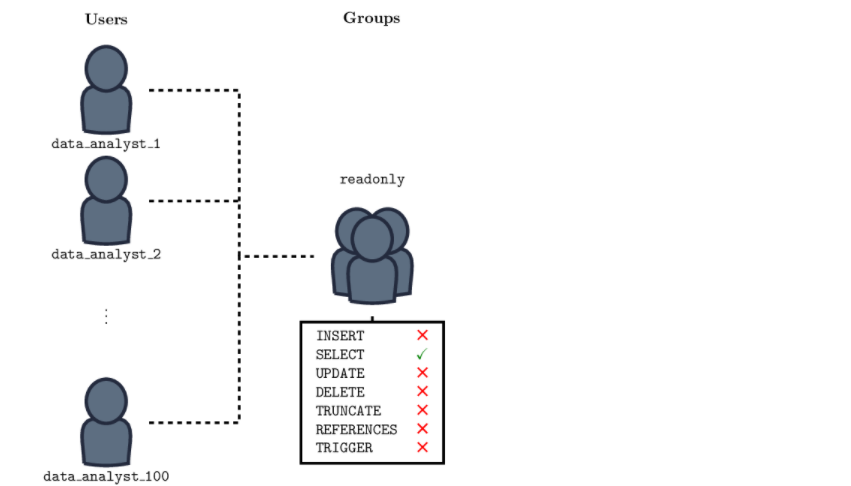

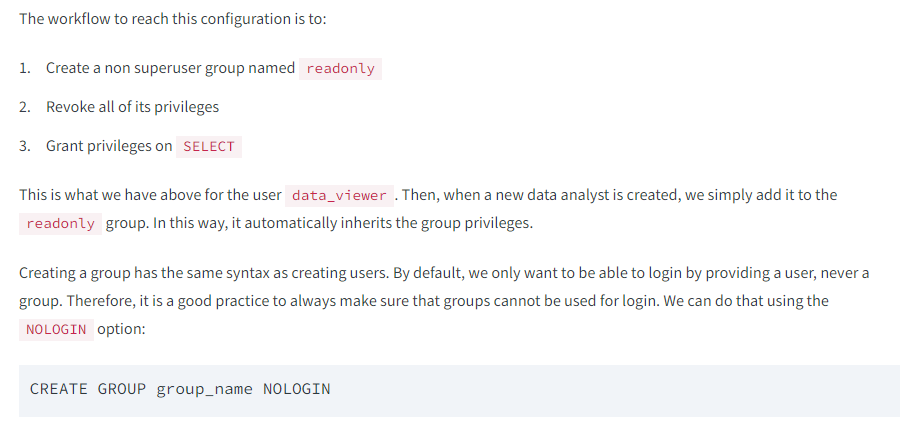

To assign a user to a group, we need to use the `GRANT` command like the following:

`GRANT group_name TO user_name`

Let's create a `readonly` group with proper privileges and assign user `data_viewer` to it.

Groups behave exactly as users, so to **grant** and **revoke** privileges to a group, we can use exactly the same syntax as we have learned before.

**Task**

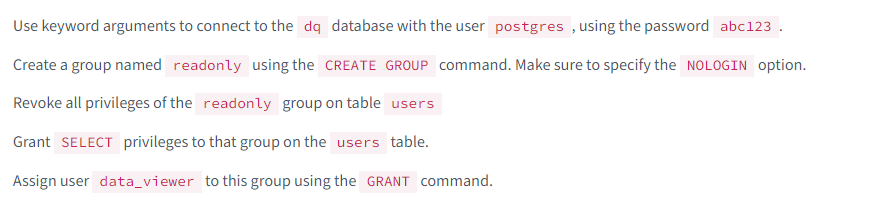

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='dq', user='postgres', password='abc123')
cur = conn.cursor()
cur.execute("CREATE GROUP readonly NOLOGIN;")
cur.execute("REVOKE ALL ON users FROM readonly;")
cur.execute("GRANT SELECT ON users TO readonly;")
cur.execute("GRANT readonly TO data_viewer;")
conn.commit()
conn.close()`

Another common group is the **readwrite** group which has privileges to **read**, **insert** and **remove** data from tables but cannot **drop** tables.

Above we drew a parallel between data analysts with the `readonly` group. In a similar way, we can think of the `readwrite` to be a suitable group for data scientists. 

Those users, like data analysts, need to be able to analyze the data but they are also responsible for collecting, cleaning the data and loading it into the database.

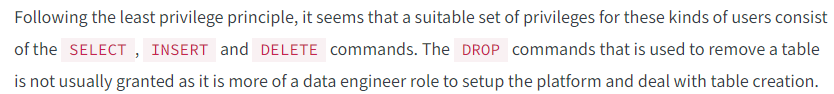 

As we have seen in the previous files, setting up the correct data types for the tables if part of our functions as a data engineer.

Note that we are not claiming that **data analysts**, **scientists** and **engineers** are defined as we described above. These roles are of course not mutually exclusive and can share common tasks. However these user groups are quite common as we can read [this blog post](https://aws.amazon.com/blogs/database/managing-postgresql-users-and-roles/).

Let's create a `readwrite` group with proper privileges.

**Task**

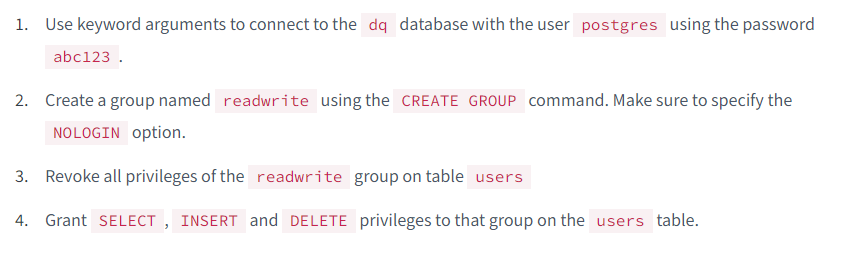

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='dq', user='postgres', password='abc123')
cur = conn.cursor()
cur.execute("CREATE GROUP readwrite NOLOGIN;")
cur.execute("REVOKE ALL ON users FROM readwrite;")
cur.execute("GRANT SELECT, INSERT, DELETE ON users TO readwrite;")
conn.commit()
conn.close()`

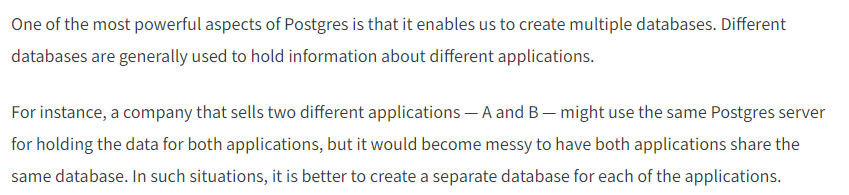

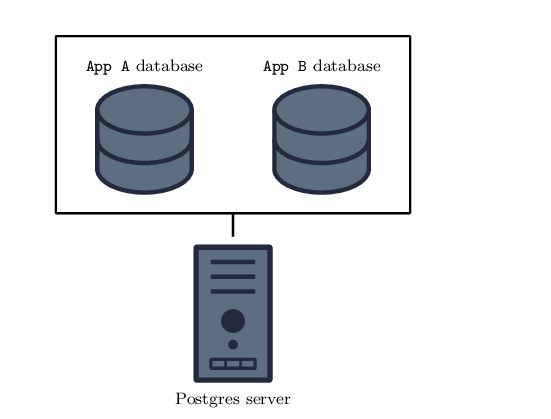

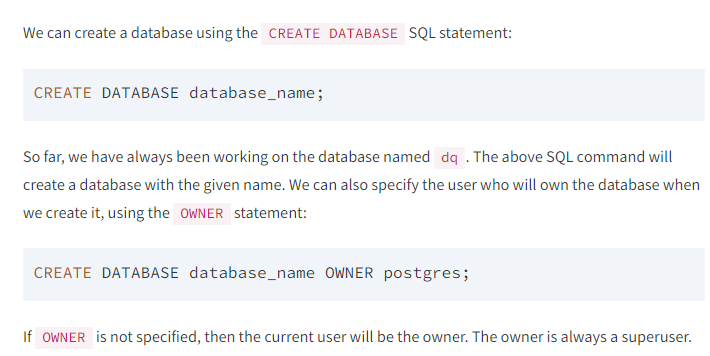

As we mentioned above, superusers are dangerous and should only be used for database administrative purposes. For small databases, we recommend to set the`postgres` user as the owner to avoid having multiple superusers.

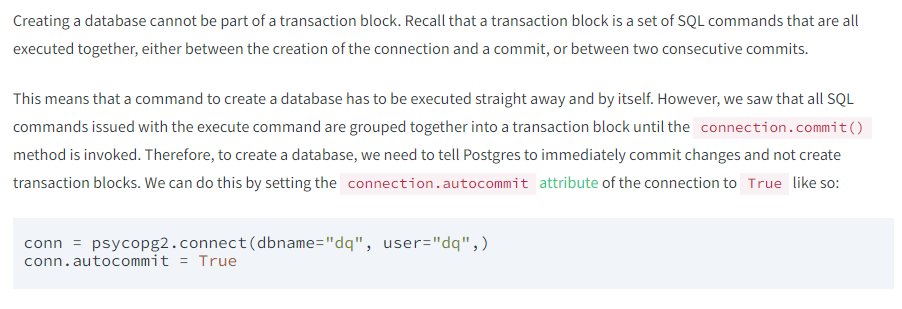

Remember to set it back to `false` after creating the database — transaction blocks are important to maintain data consistency! They make sure that groups of commands that need to be executed together are indeed executed together. 

For example when removing money from one account and adding it to another, we don't want to have only one of them executed. We want either both to be executed or none of them.

**Task**

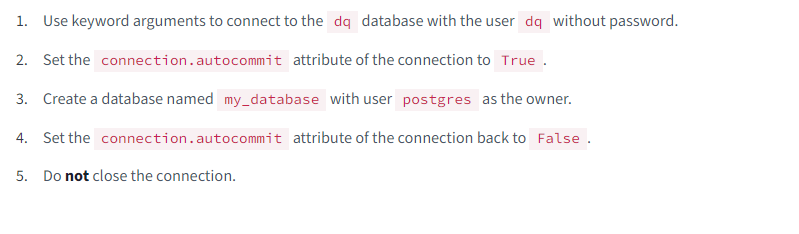

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='dq', user='dq')
conn.autocommit = True
cur = conn.cursor()
cur.execute("CREATE DATABASE my_database OWNER postgres;")
conn.autocommit = False`

Above we learned how to create databases. To ensure that our data platform is maintainable, it is important to keep separate databases for different applications, or we will quickly find ourselves with a big data mess.

**Users** and **groups** are shared across all databases. This means that unless login privileges were explicitly **revoked**, **users** can connect to any existing database. 

Of course, as with other privileges, we can and should make sure that each user only has access to the strictly necessary databases.

To revoke connection privileges of a user we need to issue the following command:

`REVOKE CONNECT ON DATABASE database_name FROM user_name;`

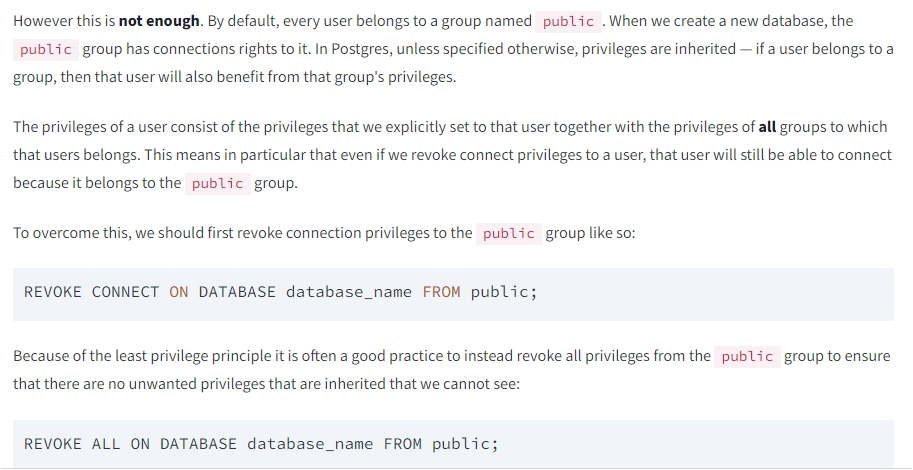

Let's do this by making sure that the `readonly` group is not allowed to connect to the `my_database` database that we have just created.

**Task**

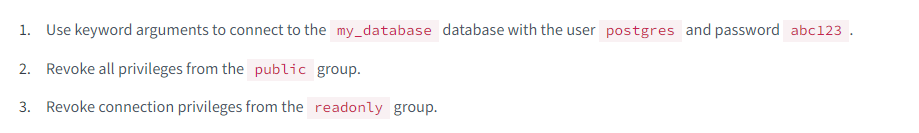

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='my_database', user='postgres', password='abc123')
cur = conn.cursor()
cur.execute("REVOKE ALL ON DATABASE my_database FROM public;")
cur.execute("REVOKE CONNECT ON DATABASE my_database FROM readonly;")
conn.commit()
conn.close()`

We learned that creating a different database for different applications is a good practice to keep our data infrastructure organized. There is another concept that helps keeping the data organized within a database: [table schemas](https://www.postgresql.org/docs/current/ddl-schemas.html).

We can think of schemas as folders for organizing the tables within a single database. By default, like for **user groups**, there exists a schema named `public` where tables are created. 

Every table that we have created so far was created in the `public` schema, since we did not specify otherwise.

The following diagram gives an overview of how a Postgres server is internally organized. The server has users and databases. The users are not tied to a specific database but rather are granted or denied access to them. A database contains schemas which in turn are composed by tables.

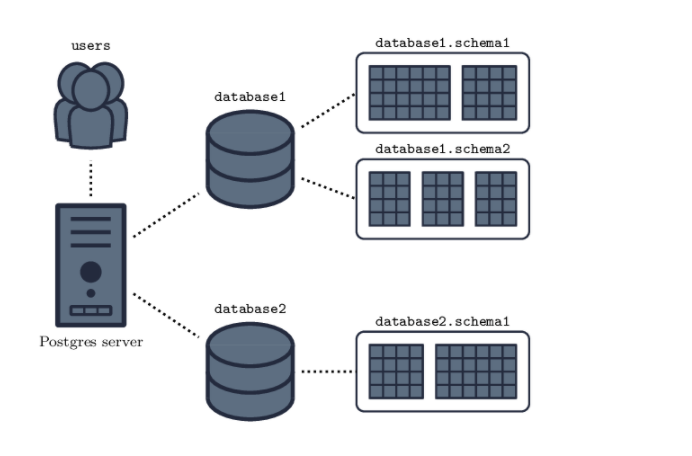

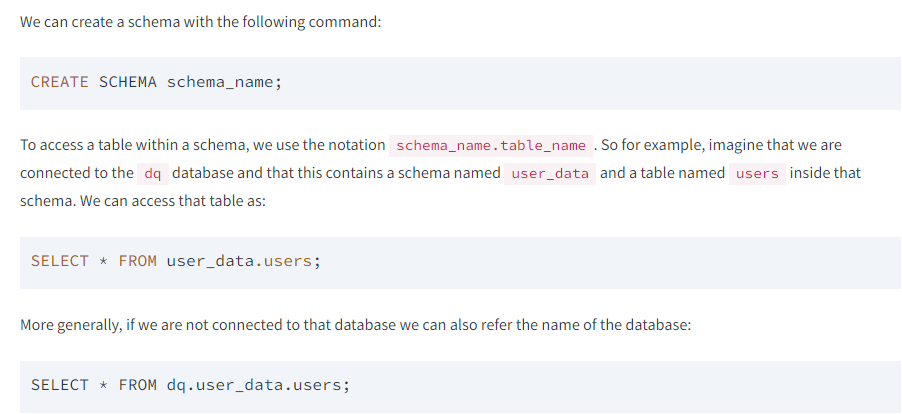

Remember that, we accessed the user rights by looking up the table `information_schema.table_privileges`. Now we can understand that this is a table named `table_privileges` located in a scheme named `information_schema`. By default, if we don't specify a schema name and provide only the table name, Postgres will look up the table in the public schema.

Previously we learned how to grant and revoke privileges of a user on a table. Our command required us to explicitly list all tables on which to apply the privileges applied — this can be quite tedious if we want to apply the same privileges to a lot of tables. We can target all tables within a give schema like so:

`REVOKE DELETE ON ALL TABLES IN schema_name TO user_name;
GRANT SELECT ON ALL TABLES IN schema_name TO user_name;`

Let's create a schema in our newly created database.

**Task**

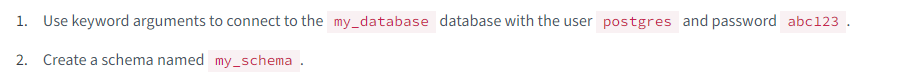

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='my_database', user='postgres', password='abc123')
cur = conn.cursor()
cur.execute("CREATE SCHEMA my_schema;")
conn.commit()
conn.close()`

In this file we learned:
    
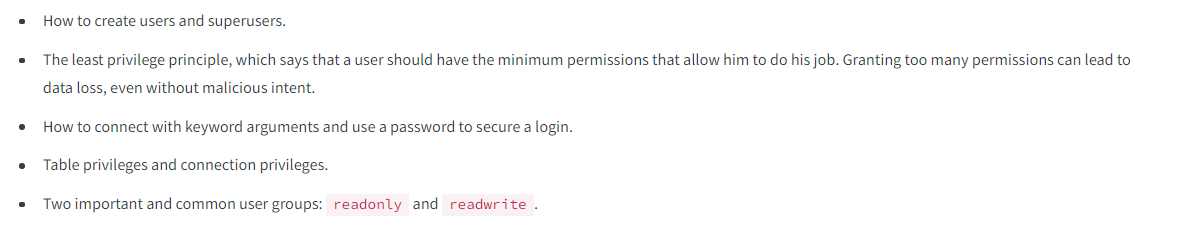